In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import torch
from torch import nn
import gin
import ray
import pickle
import io
gin.enter_interactive_mode()
from causal_util import load_env
from causal_util.helpers import lstdct2dctlst
from sparse_causal_model_learner_rl.loss.losses import fit_loss
from sparse_causal_model_learner_rl.loss.causal_discriminator import siamese_feature_discriminator_l2

from sparse_causal_model_learner_rl.metrics.context_rewrite import context_rewriter
from sparse_causal_model_learner_rl.visual.learner_visual import graph_for_matrices
from sparse_causal_model_learner_rl.config import Config
from sparse_causal_model_learner_rl.sacred_gin_tune.sacred_wrapper import load_config_files
from sparse_causal_model_learner_rl.learners.rl_learner import CausalModelLearnerRL

In [2]:
load_config_files(['../sparse_causal_model_learner_rl/configs/kc_rec_nonlin_gnn_gumbel_siamese_l2-Copy1.gin',
                   '../sparse_causal_model_learner_rl/configs/kc_dec.gin',
                   '../keychest/config/5x5_1f1c1k_obs.gin'])

['kc_rec_nonlin_gnn_gumbel_siamese_l2-Copy1', 'kc_dec', '5x5_1f1c1k_obs']

In [3]:
gin.bind_parameter('Config.collect_remotely', True)
gin.bind_parameter('Config.n_collectors', 30)
gin.bind_parameter('Config.env_steps', 5000)
gin.bind_parameter('Config.future_buffer_size', 50)
gin.bind_parameter('Normalizer.type_', 'meanstd')
gin.bind_parameter('ManyNetworkCombinedModel.input_batchnorm', True)
gin.bind_parameter('ExperienceReplayBuffer.buffer_limit_steps', 100000)
gin.bind_parameter('ExperienceReplayBuffer.minibatch_size', 5000)

In [4]:
ray.init(ignore_reinit_error=True)

2021-02-06 01:35:34,107	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '10.90.38.7',
 'raylet_ip_address': '10.90.38.7',
 'redis_address': '10.90.38.7:6379',
 'object_store_address': '/tmp/ray/session_2021-02-06_01-35-33_559328_31687/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-02-06_01-35-33_559328_31687/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-02-06_01-35-33_559328_31687',
 'metrics_export_port': 57873,
 'node_id': '1fdb06cd8f63a36e028ceb4e46ab3c02b48ce823'}

In [5]:
# gin.bind_parameter('decoder/FCNet.hidden_sizes', [512, 256])
# gin.bind_parameter('decoder/FCNet.activation_cls', torch.nn.LeakyReLU)

In [6]:
gin.bind_parameter('decoder/FCNet.hidden_sizes', [512])
gin.bind_parameter('decoder/FCNet.activation_cls', torch.nn.LeakyReLU)

In [7]:
learner = CausalModelLearnerRL(Config(ray_kwargs={'address': '127.0.0.1:6379'}))

2021-02-06 01:35:35,946	WARNING session.py:20 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Selecting name 3a7aa628-6813-11eb-8ff1-90e2baa1a248
Make environment KeyChest-v0 None {}


In [8]:
learner.create_trainables()

In [9]:
learner.decoder

ModelDecoder(
  (model): FCNet(
    (fc01): Linear(in_features=847, out_features=512, bias=True)
    (fc02): Linear(in_features=512, out_features=30, bias=True)
  )
)

In [10]:
env = learner.env

In [11]:
losses = []
dclose = []
dfar = []

In [12]:
opt = torch.optim.Adam(lr=5e-4, params=learner.decoder.parameters())

In [13]:
for i in tqdm(range(1000)):
    if i % 1 == 0:
        ctx = learner.collect_and_get_context()
    
    opt.zero_grad()
    l_obj = siamese_feature_discriminator_l2(**ctx)
    loss = l_obj['loss']
    loss.backward()
    opt.step()
    losses.append(loss.item())
    dclose.append(l_obj['metrics']['distance_close'])
    dfar.append(l_obj['metrics']['distance_far'])

(pid=31958) Make environment KeyChest-v0 None {}
(pid=31976) Make environment KeyChest-v0 None {}
(pid=31964) Make environment KeyChest-v0 None {}
(pid=31963) Make environment KeyChest-v0 None {}
(pid=31955) Make environment KeyChest-v0 None {}
(pid=31952) Make environment KeyChest-v0 None {}
(pid=31950) Make environment KeyChest-v0 None {}
(pid=31965) Make environment KeyChest-v0 None {}
(pid=31975) Make environment KeyChest-v0 None {}
(pid=31930) Make environment KeyChest-v0 None {}
(pid=31933) Make environment KeyChest-v0 None {}
(pid=31971) Make environment KeyChest-v0 None {}
(pid=31938) Make environment KeyChest-v0 None {}
(pid=31977) Make environment KeyChest-v0 None {}
(pid=31947) Make environment KeyChest-v0 None {}
(pid=31917) Make environment KeyChest-v0 None {}
(pid=31957) Make environment KeyChest-v0 None {}
(pid=31928) Make environment KeyChest-v0 None {}
(pid=31919) Make environment KeyChest-v0 None {}
(pid=31972) Make environment KeyChest-v0 None {}
(pid=31956) Make env

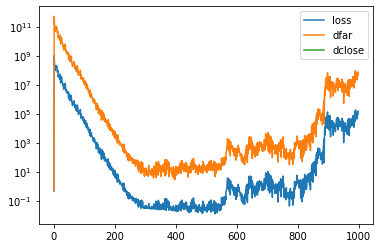

In [15]:
plt.plot(losses, label='loss')
plt.plot(dfar, label='dfar')
plt.plot(dclose, label='dclose')
plt.yscale('log')
plt.legend()

In [17]:
np.mean(losses[-50:]), np.median(losses[-50:])

(0.0, 0.0)

In [18]:
ctx = learner.collect_and_get_context()

In [19]:
features = learner.decoder(ctx['obs'])

In [20]:
f = features.detach().cpu().numpy()

In [21]:
f.shape

(5000, 30)

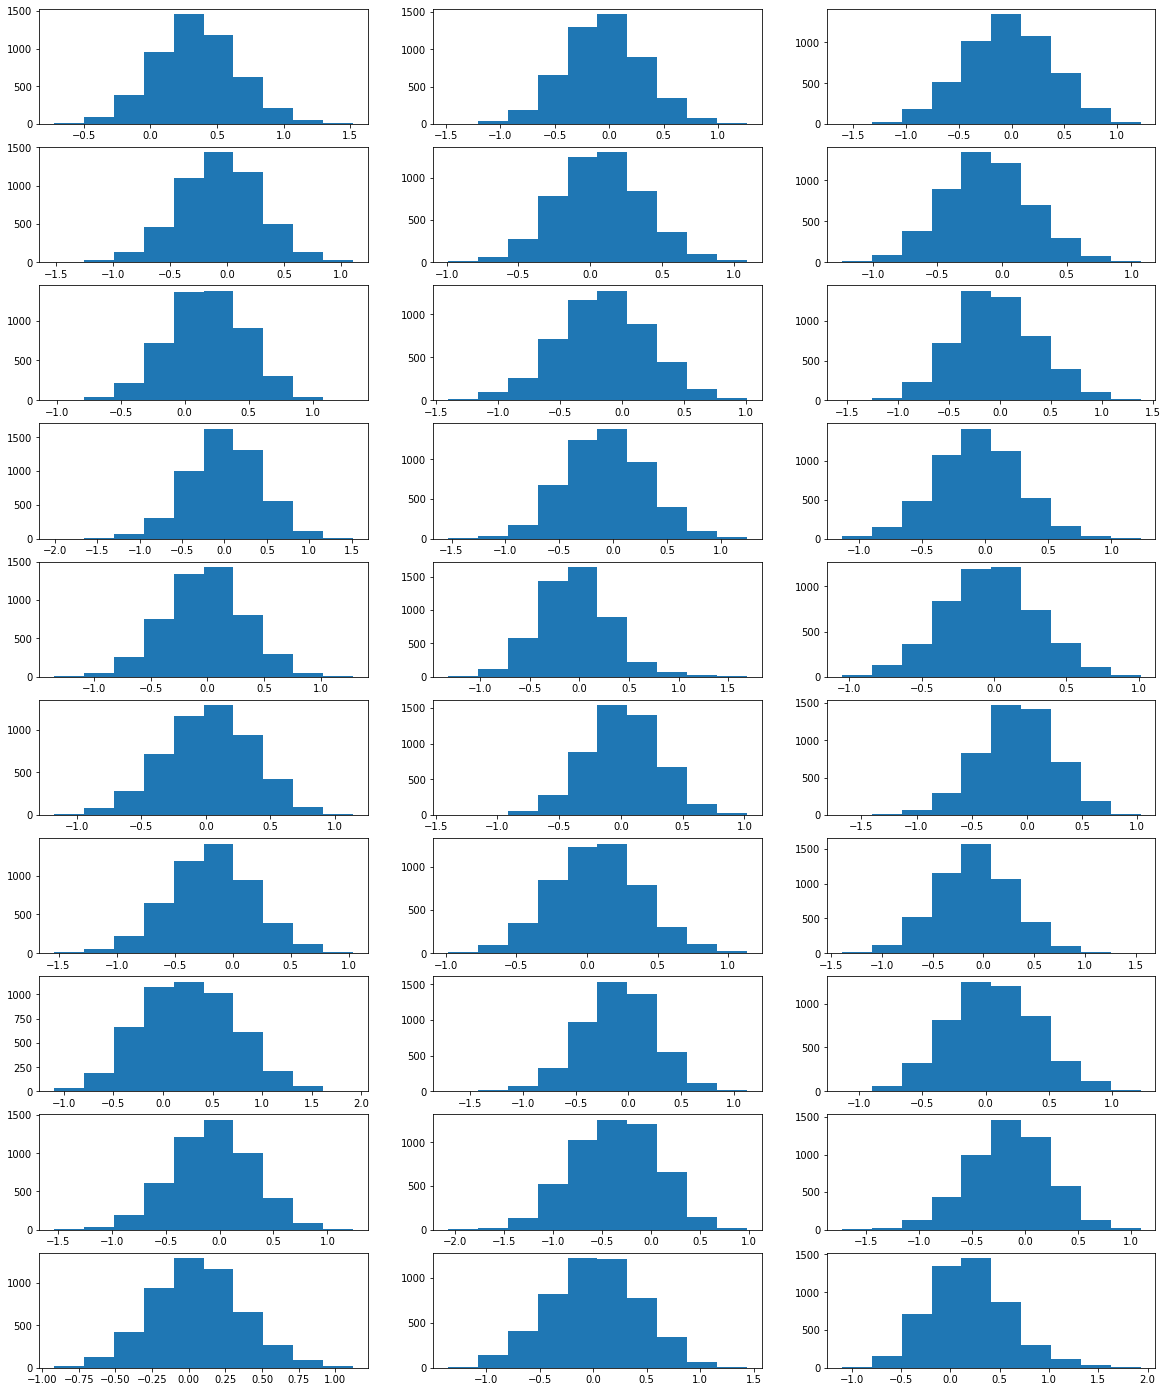

In [30]:
plt.figure(figsize=(20, 25))
for i_f in range(f.shape[1]):
    plt.subplot(10, 3, i_f + 1)
    plt.hist(f[:, i_f])

In [31]:
pd.DataFrame(f).std()

0     0.310318
1     0.361259
2     0.409465
3     0.356164
4     0.298617
5     0.333191
6     0.307728
7     0.365080
8     0.408356
9     0.423165
10    0.376213
11    0.333983
12    0.347997
13    0.360253
14    0.320849
15    0.342611
16    0.294377
17    0.338356
18    0.361129
19    0.313156
20    0.372215
21    0.468361
22    0.351277
23    0.350832
24    0.372429
25    0.425889
26    0.377701
27    0.304172
28    0.423119
29    0.401315
dtype: float32

<AxesSubplot:>

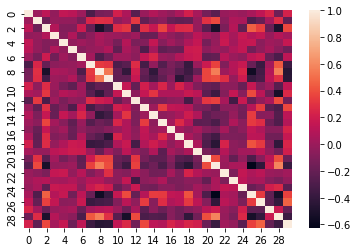

In [32]:
sns.heatmap(pd.DataFrame(f).corr())

In [33]:
env.engine.return_rgb = False

In [64]:
gin.bind_parameter('model_gnn/FCCombinedModel.activation_cls', torch.nn.LeakyReLU)
gin.bind_parameter('model_gnn/FCCombinedModel.hidden_sizes', [100, 100, 100])

In [65]:
learner.non_sparse_model.__init__(feature_shape=learner.feature_shape,
                                  action_shape=learner.action_shape,
                                  additional_feature_shape=learner.additional_feature_shape)
learner.non_sparse_model = learner.non_sparse_model.cuda()

In [66]:
learner.non_sparse_model.model.model.activation

[LeakyReLU(negative_slope=0.01),
 LeakyReLU(negative_slope=0.01),
 LeakyReLU(negative_slope=0.01),
 None]

In [67]:
learner.non_sparse_model

ManyNetworkCombinedModel(
  (bn): BatchNorm1d(34, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (model): WithInputSwitch(
    (switch): LearnableSwitchSimple()
    (model): FCCombinedModel(
      (fc01): CombinedLinearLayer()
      (fc02): CombinedLinearLayer()
      (fc03): CombinedLinearLayer()
      (fc04): CombinedLinearLayer()
    )
  )
)

In [68]:
learner.non_sparse_model.model.enable_switch

False

In [69]:
mins = None
maxes = None

In [70]:
def normalize(t, mins, maxes):
    return 2 * ((t - mins) / (1e-3 + maxes - mins) - 0.5)

In [71]:
class AdhocWorldModel(nn.Module):
    def __init__(self):
        super(AdhocWorldModel, self).__init__()
        dim = 60
        self.bn = torch.nn.BatchNorm1d(num_features=34)
        self.fc1 = nn.Linear(in_features=34, out_features=dim)
        self.fc2 = nn.Linear(in_features=dim, out_features=dim)
        self.fc3 = nn.Linear(in_features=dim, out_features=dim)
        self.fc4 = nn.Linear(in_features=dim, out_features=32)
        self.activation = nn.Tanh()
        
    def forward(self, f_t, a_t, all):
        x = torch.cat([f_t, a_t], dim=1)
        
        x = self.bn(x)
        
        x = self.fc1(x)
        x = self.activation(x)
        
        x = self.fc2(x)
        x = self.activation(x)
        
        x = self.fc3(x)
        x = self.activation(x)
        
        x = self.fc4(x)
        return x

In [72]:
losses = []
metrics = []
losses_emb = []
losses_fit = []
ctx_set = False

In [73]:
use_model = learner.non_sparse_model
#use_model = AdhocWorldModel().cuda()

In [74]:
gin.bind_parameter('decoder/FCNet.hidden_sizes', [512])
gin.bind_parameter('decoder/FCNet.activation_cls', torch.nn.LeakyReLU)

In [75]:
learner.decoder.__init__(observation_shape=learner.observation_shape,
                         feature_shape=learner.feature_shape)
learner.decoder = learner.decoder.cuda()

In [91]:
opt = torch.optim.Adam(lr=1e-4, params=list(use_model.parameters())+list(learner.decoder.parameters()))

In [92]:
def fit_loss(obs_x, obs_y, action_x, decoder, model, additional_feature_keys,
             model_forward_kwargs=None,
             fill_switch_grad=False,
             opt_label=None,
             divide_by_std=False,
             std_eps=0.05,
             **kwargs):
    """Ensure that the model fits the features data."""

    if model_forward_kwargs is None:
        model_forward_kwargs = {}
    
    f_t1 = decoder(obs_y)#.detach()
        
    have_additional = False
    if additional_feature_keys:
        have_additional = True
        add_features_y = torch.cat([kwargs[k] for k in additional_feature_keys], dim=1)
        
        # WARNING: zeroing output features
#         f_t1 = torch.zeros_like(f_t1)
        f_t1 = torch.cat([f_t1, add_features_y], dim=1)
        
    # detaching second part like in q-learning makes the loss jitter

    f_t1_pred = model(decoder(obs_x), action_x, all=have_additional, **model_forward_kwargs)

    loss = (f_t1_pred - f_t1).pow(2)
    loss = loss.sum(1).mean()

    metrics = {'mean_feature': f_t1.mean(0).detach().cpu().numpy(),
               'std_feature': f_t1.std(0).detach().cpu().numpy(),
               'min_feature': f_t1.min().item(),
               'max_feature': f_t1.max().item(),
               #'std_feature_avg': f_t1_std.detach().cpu().numpy() if f_t1_std is not None else 0.0,
               #'inv_std_feature_avg': 1/f_t1_std.detach().cpu().numpy() if f_t1_std is not None else 0.0
              }

    return {'loss': loss,
            'metrics': metrics}

In [93]:
[x.mean() for x in learner.decoder.state_dict().values()]

[tensor(0.0006, device='cuda:0'),
 tensor(-0.0827, device='cuda:0'),
 tensor(-0.0002, device='cuda:0'),
 tensor(0.0033, device='cuda:0')]

In [100]:
for i in tqdm(range(50000)):
    if i % 1 == 0 or not ctx_set:
        ctx_set = True
        ctx = learner.collect_and_get_context()
        
#         if mins is None or maxes is None:
#             print("Computing minmax")
#             f_all = learner.decoder(ctx['obs'])
#             mins = f_all.min(dim=0, keepdim=True).values.detach()
#             maxes = f_all.max(dim=0, keepdim=True).values.detach()
        
#         f_t1 = learner.decoder(ctx['obs_y'])#.detach()
#         f_t = learner.decoder(ctx['obs_x'])#.detach()
        
# #         f_t1 = normalize(f_t1, mins, maxes)
# #         f_t = normalize(f_t, mins, maxes)
        
#         add_features_y = torch.cat([ctx[k] for k in ctx['additional_feature_keys']], dim=1)
#         f_t1 = torch.cat([f_t1, add_features_y], dim=1)
        
#     f_t1_pred = use_model(
#         f_t,
#         ctx['action_x'],
#         all=True)
    
    ctx['non_sparse_model_add'] = use_model
#     ctx['additional_feature_keys'] = []
    l_obj_emb = siamese_feature_discriminator_l2(**ctx)
    l_obj_fit = context_rewriter(function=fit_loss, rewrite={'model': 'non_sparse_model_add'},
                                 divide_by_std=False,
                                 **ctx)
    loss = l_obj_fit['loss'] #+ l_obj_emb['loss']

    
#     loss = nn.MSELoss()(f_t1, f_t1_pred)

    
    opt.zero_grad()
    loss.backward()
    opt.step()
    losses.append(loss.item())
    losses_emb.append(l_obj_emb['loss'].item())
    losses_fit.append(l_obj_fit['loss'].item())
    m = {}
    m.update(l_obj_fit['metrics'])
    m.update(l_obj_emb['metrics'])
    metrics.append(m)

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

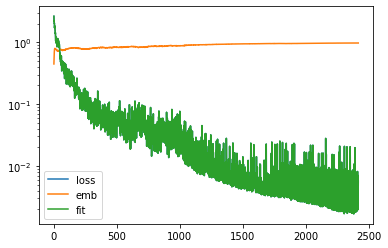

In [101]:
plt.plot(losses, label='loss')
plt.plot(losses_emb, label='emb')
plt.plot(losses_fit, label='fit')
#plt.plot(dplus, label='dplus')
plt.yscale('log')
plt.legend()

In [102]:
%%javascript
var jq = document.createElement('script');
jq.src = "https://ajax.googleapis.com/ajax/libs/jquery/2.1.4/jquery.min.js";
document.getElementsByTagName('head')[0].appendChild(jq);

<IPython.core.display.Javascript object>

In [103]:
%load_ext jupyternotify
%autonotify -a 30

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [104]:
f_t1 = learner.decoder(ctx['obs_y'])#.detach()
f_t = learner.decoder(ctx['obs_x'])#.detach()

#         f_t1 = normalize(f_t1, mins, maxes)
#         f_t = normalize(f_t, mins, maxes)

add_features_y = torch.cat([ctx[k] for k in ctx['additional_feature_keys']], dim=1)
# f_t1 = torch.zeros_like(f_t1)
f_t1 = torch.cat([f_t1, add_features_y], dim=1)

f_t1_pred = use_model(
f_t,
ctx['action_x'],
all=True)


<AxesSubplot:>

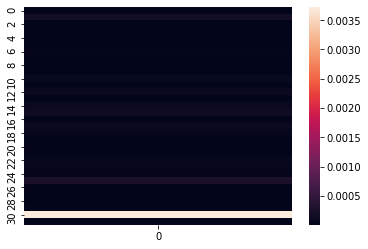

In [105]:
sns.heatmap((f_t1_pred - f_t1).pow(2).mean(0).cpu().detach().numpy().reshape(-1, 1))

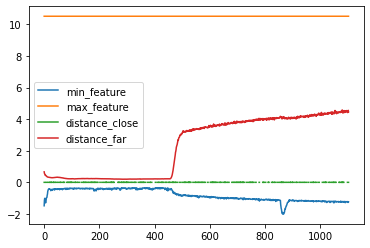

In [62]:
metrics_dct = lstdct2dctlst(metrics)
for key, vals in metrics_dct.items():
    if len(np.array(vals).shape) > 1: continue
    plt.plot(vals, label=key)
plt.legend()
plt.show()

In [48]:
metrics_dct.keys()

dict_keys(['mean_feature', 'std_feature', 'min_feature', 'max_feature', 'distance_plus', 'distance_minus'])

In [49]:
losses[-1]

0.018160220235586166

In [50]:
learner.decoder(ctx['obs_x']).min()

tensor(-0.2716, device='cuda:0', grad_fn=<MinBackward1>)

In [51]:
# metrics_dct['']